In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops, regionprops_table
from skimage.morphology import closing, square
from skimage.color import label2rgb

import scipy.optimize as sc
from PIL import Image
import pandas as pd

import os
import sys

def model_processing(im_name, iter_num, path=None):
    
    '''
    in: image, iteration number (to save data), saving path with / in the end ('home/' , not 'home')
    out: params in npy, images of distributions
    returns nothing
    '''
    cell_ex = Image.open(str(im_name))
    cell_gr = cell_ex.convert('L')
#     cell_ex_arr = np.array(cell_ex)
    cell_ex_arr_gr = np.array(cell_gr)
    
    # image = data.coins()[50:-50, 50:-50]
    image = cell_ex_arr_gr[50:-50, 50:-50]

    # apply threshold
    thresh = threshold_otsu(image)
    bw = closing(image<100, square(3))
    plt.imshow(bw)
    bw2 = closing(50<image, square(3))
    plt.imshow(bw2)
    bw3 = closing(bw*bw2, square(3))
    plt.imshow(bw3)

    # remove artifacts connected to image border
    cleared = clear_border(bw3)

    # label image regions
    label_image = label(cleared)
    # to make the background transparent, pass the value of `bg_label`,
    # and leave `bg_color` as `None` and `kind` as `overlay`
#     image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

    cell_table = regionprops_table(label_image, 
                            properties=['label', 'area', 'perimeter', 'convex_area',
                                        'feret_diameter_max', 'bbox']) #CHOOSING PARAMS
    cell_df = pd.DataFrame(cell_table)
    for i in range(len(cell_df)):
        if cell_df['area'][i] < 60:
            cell_df = cell_df.drop(i)
    area_ratio = np.array([convex_area / area for convex_area, area
                           in zip(cell_df['convex_area'], cell_df['area'])])
    def norm(x, A, mu, sigma):
        return A / sigma * np.exp(-(x - mu)**2 / (2*sigma**2))

    '''
    Придется выбирать начальное приближение для каждого отношения площадей
    (или отказаться от него, раз есть обе площади)
    '''

    fig,axs = plt.subplots(nrows=2,ncols=2, figsize=(12, 10))
    res_arr = []
    sigma_arr = []
    param_arr = []

    axs[0,0].set_title('area')
    area_y = axs[0,0].hist(cell_df['area'])[0]
    area_x = axs[0,0].hist(cell_df['area'])[1]
    try:
        res_ar, sigma_ar = sc.curve_fit(norm, area_x[:-1], area_y, p0=[100,100,100])
        axs[0,0].plot(area_x[:-1], norm(area_x[:-1], res_ar[0], res_ar[1], res_ar[2]))
        res_arr.append(res_ar)
        sigma_arr.append(np.diag(np.sqrt(sigma_ar)))
        param_arr.append('area')
    except:
        axs[0,0].plot(area_x[:-1], area_y, 'r')
        print('ERROR IN AREA APPROX, iter {}'.format(iter_num))

    axs[0,1].set_title('convex_area')
    con_y = axs[0,1].hist(cell_df['convex_area'])[0]
    con_x = axs[0,1].hist(cell_df['convex_area'])[1]
    try:
        res_con, sigma_con = sc.curve_fit(norm, con_x[:-1], con_y, p0=[100,100,100])
        axs[0,1].plot(con_x[:-1], norm(con_x[:-1], res_con[0], res_con[1], res_con[2]))
        res_arr.append(res_con)
        sigma_arr.append(np.diag(np.sqrt(sigma_con)))
        param_arr.append('convex_area')
    except:
        axs[0,1].plot(con_x[:-1], con_y, 'r')
        print('ERROR IN CONVEX APPROX, iter {}'.format(iter_num))

    axs[1,0].set_title('feret_diameter_max')
    diam_y = axs[1,0].hist(cell_df['feret_diameter_max'])[0]
    diam_x = axs[1,0].hist(cell_df['feret_diameter_max'])[1]
    try:
        res_diam, sigma_diam = sc.curve_fit(norm, diam_x[:-1], diam_y, p0=[100,10,100])
        axs[1,0].plot(diam_x[:-1], norm(diam_x[:-1], res_diam[0], res_diam[1], res_diam[2]))
        res_arr.append(res_diam)
        sigma_arr.append(np.diag(np.sqrt(sigma_diam)))
        param_arr.append('diam')
    except:
        axs[1,0].plot(diam_x[:-1], diam_y, 'r')
        print('ERROR IN DIAM APPROX, iter {}'.format(iter_num))

    axs[1,1].set_title('area_ratio')
    s_ratio_y = axs[1,1].hist(area_ratio)[0]
    s_ratio_x = axs[1,1].hist(area_ratio)[1]
    try:
        res_rat, sigma_rat = sc.curve_fit(norm, s_ratio_x[:-1], s_ratio_y)
        axs[1,1].plot(s_ratio_x[:-1], norm(s_ratio_x[:-1], res_rat[0], res_rat[1], res_rat[2]))
        res_arr.append(res_rat)
        sigma_arr.append(np.diag(np.sqrt(sigma_rat)))
        param_arr.append('ratio')
    except:
        axs[1,1].plot(s_ratio_x[:-1], s_ratio_y, 'r')
        print('ERROR IN S_RATIO APPROX, iter {}'.format(iter_num))

    # # axs[1,1].hist(area_ratio)
    # axs[2,1].set_title('bbox')
    # bbox_y = axs[2,1].hist([cell_df['bbox-2'][0][i] - cell_df['bbox-0'][0][i] for i in 
    #           range(len(cell_df['bbox-2'][0]))])[0]
    # bbox_x = [axs[2,1].hist(cell_df['bbox-2'])[1][i] - axs[2,1].hist(cell_df['bbox-0'])[1][i] for
    #           i in range(len(axs[2,1].hist(cell_df['bbox-2'])[1]))]
    # try:
    #     res_bbox, sigma_bbox = sc.curve_fit(norm, bbox_x[:-1], bbox_y)
    #     axs[2,1].plot(bbox_x[:-1], norm(bbox_x[:-1], res_bbox[0], res_bbox[1], res_bbox[2]))
    #     res_arr.append(res_bbox)
    #     sigma_arr.append(np.diag(np.sqrt(sigma_bbox)))
    #     param_arr.append('bbox')
    # except:
    #     axs[2,1].plot(bbox_x[:-1], bbox_y, 'r')
    #     print('ERROR IN WIDTH APPROX, iter {}'.format(iter_num))
    if path == None:
        plt.savefig('approx_{}.jpeg'.format(iter_num))
        uni_npy = np.array([param_arr, res_arr, sigma_arr])
        np.save('current_par_{}.npy'.format(iter_num), uni_npy)
    else:
        plt.savefig(str(path)+'approx_{}.jpeg'.format(iter_num))
        uni_npy = np.array([param_arr, res_arr, sigma_arr])
        npy_path=str(path)+'current_par_{}.npy'.format(iter_num)
        np.save(npy_path, uni_npy)
  
print(sys.argv[1])      
iters = int(float(sys.argv[1]))
        
for i in range(iters):
	path_0 = '/home/andrey/last_backup_0107/vct_pdms_edge/'
	path = str(path_0)+'imgs_{}/example01000.png'.format(i)
	model_processing(path, i, path_0)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops, regionprops_table
from skimage.morphology import closing, square
from skimage.color import label2rgb

import scipy.optimize as sc
from PIL import Image
import pandas as pd

import os
import sys

In [3]:
cm = np.load('current_par_0.npy', allow_pickle=True)

In [7]:
pd.DataFrame(cm)

,0,1,2,3
0,area,convex_area,diam,ratio
1,"[851.4054686908768, 54.94397098060298, 12.3697...","[835.9350096781978, 87.98267129418737, 12.5308...","[90.020952220295, 13.542125583246646, 1.781492...","[7.86405640172179, 1.3170009698837215, 0.15032..."
2,"[486.06966866372244, 7.903980147150255, 3.9745...","[60.90971272575563, 1.0294476445439518, 1.1024...","[12.121224637326804, 0.26549836846926206, 0.29...","[0.9809518556892913, 0.020993688275492417, 0.0..."


In [8]:
cm

array([['area', 'convex_area', 'diam', 'ratio'],
       [array([851.40546869,  54.94397098,  12.36979381]),
        array([835.93500968,  87.98267129,  12.5308366 ]),
        array([90.02095222, 13.54212558,  1.78149262]),
        array([7.8640564 , 1.31700097, 0.15032788])],
       [array([486.06966866,   7.90398015,   3.97456947]),
        array([60.90971273,  1.02944764,  1.10240376]),
        array([12.12122464,  0.26549837,  0.29841539]),
        array([0.98095186, 0.02099369, 0.02290972])]], dtype=object)

In [9]:
len(cm)

3

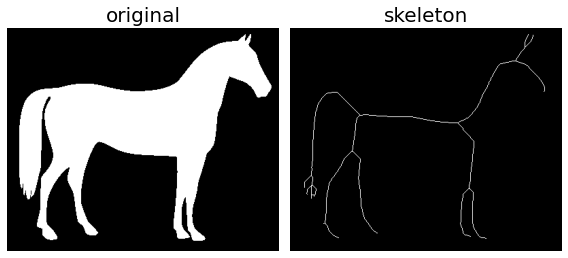

In [10]:
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert

# Invert the horse image
image = invert(data.horse())

# perform skeletonization
skeleton = skeletonize(image)

# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

fig.tight_layout()
plt.show()
